In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy import stats
import statsmodels.api as sm
DATA_PATH="data/dump_4_modelli_e_large/"
CPU_DATA_PATH="data/cpu_usage_studio/"
IMG_PATH="img/"

In [ ]:


def get_folder_names(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

class Experiment:
    def __init__(self, name):
        self.name = name
        self.color = None  # Placeholder for color, can be set later if needed
        self.repetitions = 1  # Default value, can be adjusted later
        # Raw data
        self._raw_swap = []  
        self._raw_inference = []
        self._raw_fps = []
        self._raw_cpu_usage = []
        # Data
        self.swap = None
        self.inference = None
        self.fps = None
        self.cpu_usage = None

    def load_csv(self, name, path):
        file_path = os.path.join(path, f"{name}.csv")
        if os.path.exists(file_path):
            return pd.read_csv(file_path)
        else:
            print(f"[ERROR] Data file {file_path} does not exist.")
            return pd.DataFrame()
    def load_data(self, path=None):
        self._raw_swap.append(self.load_csv("cpu_ram_swap", path))
        self._raw_fps.append(self.load_csv("fps_status", path))
        self._raw_inference.append(self.load_csv("inference_time", path))
        self._raw_cpu_usage.append(self.load_csv("cpu_per_process", path))
        self.repetitions = len(self._raw_swap)
    
    def _padding(self, dataframe):
        # Find the maximum number of rows among all _raw_swap datasets
            max_len = max(len(df) for df in dataframe)
            # Pad each DataFrame to max_len with NaNs if necessary
            new_dataframe = [
                df.reindex(range(max_len)).reset_index(drop=True)
                for df in dataframe
            ]
            return new_dataframe
    
    def _process_raw(self, dataframe, ci = 0.90):
        pad_df = self._padding(dataframe)
        col_names = pad_df[0].columns.tolist()
        # Escludi 'ID' dai nomi delle colonne numeriche
        col_names = [col for col in col_names if col != 'ID']
        # Calcola la media e l'intervallo di confidenza al 95% per ogni colonna numerica
        mean_df = pd.DataFrame(np.nanmean([df.values for df in pad_df], axis=0), columns=pad_df[0].columns)
        sem_df = pd.DataFrame(stats.sem([df.values for df in pad_df], axis=0, nan_policy='omit'), columns=pad_df[0].columns)
        ci95 = stats.t.ppf(ci, df=self.repetitions - 1) * sem_df  # 95% confidence interval

        # Aggiungi le colonne degli intervalli di confidenza al dataframe
        for col in col_names:
            mean_df[f'{col}_ci_lower'] = mean_df[col] - ci95[col]
            mean_df[f'{col}_ci_upper'] = mean_df[col] + ci95[col]
        return mean_df

    def process_all_raw(self):
        if self._raw_swap:
            self.swap = self._process_raw(self._raw_swap)
        if self._raw_fps:
            self.fps = self._process_raw(self._raw_fps)
        if self._raw_inference:
            self.inference = self._process_raw(self._raw_inference)
        if self._raw_cpu_usage:
            self.cpu_usage = self._process_raw(self._raw_cpu_usage)

class ExperimentManager:
    def __init__(self, data_path=DATA_PATH):
        self.data_path = data_path
        self.experiments = {}
        self.line_dark_colors = ['#32CD32', '#1E90FF', '#FF69B4', '#FFD700','#9A68C4', '#1EA896']  # Dark color for lines
        self.index = 0  # Index for cycling through colors
        self._dark_mode = False  # Flag to indicate dark mode
    
    def _get_line_color(self):
        """Get a dark color for the line based on the current index."""
        if self._dark_mode:
            color = self.line_dark_colors[self.index % len(self.line_dark_colors)]
        else:
            # Use a colormap for light mode, cycling through tab10 colors
            color = plt.cm.tab10(self.index % 10)
        self.index += 1
        return color
    
    

    def _lighten_color(self, hex_color, amount=0.2):
        """
        Schiarisce un colore esadecimale.
        `amount` va da 0 (nessuna modifica) a 1 (bianco).
        """
        try:
            c = mcolors.cnames[hex_color]
        except:
            c = hex_color
        r, g, b = mcolors.to_rgb(c)
        # Interpolazione verso il bianco
        r += (1.0 - r) * amount
        g += (1.0 - g) * amount
        b += (1.0 - b) * amount
        return mcolors.to_hex((r, g, b))
    
    def save_figure(self, fig, filename):
        """
        Salva la figura in formato PNG.
        :param fig: matplotlib figure object
        :param filename: str, nome del file senza estensione
        """
        fig.savefig(os.path.join(IMG_PATH, f"{filename}.png"), transparent=True)
        print(f"[INFO] Plot saved to {os.path.join(IMG_PATH, f'{filename}.png')}")

    
    def set_dark_mode(self, dark_mode):
        """
        Set the dark mode for the plots.
        :param dark_mode: bool, if True, use dark mode colors.
        """
        self._dark_mode = dark_mode
        if dark_mode:
            plt.style.use('dark_background')
            plt.rcParams['axes.facecolor'] = '#131524'
            plt.rcParams['figure.facecolor'] = '#131524'
        else:
            plt.style.use('default')
            plt.rcParams['axes.facecolor'] = 'white'
            plt.rcParams['figure.facecolor'] = 'white'

    def init_all(self):
        folder_names = get_folder_names(self.data_path)
        for folder in folder_names:
            # Remove leading timestamp (assumes format: YYYYMMDD_HHMMSS_name)
            parts = folder.split('_', 2)
            if len(parts) == 3:
                exp_name = parts[2]
            else:
                exp_name = folder
            #print(f"[INFO] Loading experiment: {exp_name}")
            exp_path = os.path.join(self.data_path, folder)
            if os.path.isdir(exp_path):
                if exp_name not in self.experiments:
                    if self._dark_mode:
                        color = self._get_line_color()
                    else:
                        color = plt.cm.tab10(len(self.experiments) % 10)
                    experiment = Experiment(exp_name)
                    experiment.color = color
                    experiment.load_data(exp_path)
                    self.experiments[exp_name] = experiment
                else:
                    #print(f"[INFO] New repetition {exp_name} found, loading data.")
                    self.experiments[exp_name].load_data(exp_path)
        for exp in self.experiments.values():
            exp.process_all_raw()
            print(f"[INFO] Experiment {exp.name} loaded with {exp.repetitions} repetitions.")

    def get_experiment(self, name):
        return self.experiments.get(name)
    
    def plot_cpu_ram_swap(self, plotci=False, save = False):
        fig, axs = plt.subplots(3, 1, figsize=(12, 12))
        for name, exp in self.experiments.items():
            if exp.swap is not None:
                # CPU
                axs[0].plot(exp.swap['ID'], exp.swap['CPU_percent'], label=name, color=exp.color)
                if 'CPU_percent_ci_lower' in exp.swap and 'CPU_percent_ci_upper' in exp.swap and plotci == True:
                    axs[0].fill_between(
                        exp.swap['ID'],
                        exp.swap['CPU_percent_ci_lower'],
                        exp.swap['CPU_percent_ci_upper'],
                        color=exp.color,
                        alpha=0.2
                    )
                # RAM
                axs[1].plot(exp.swap['ID'], exp.swap['RAM_percent'], label=name, color=exp.color)
                if 'RAM_percent_ci_lower' in exp.swap and 'RAM_percent_ci_upper' in exp.swap and plotci == True:
                    axs[1].fill_between(
                        exp.swap['ID'],
                        exp.swap['RAM_percent_ci_lower'],
                        exp.swap['RAM_percent_ci_upper'],
                        color=exp.color,
                        alpha=0.2
                    )
                # SWAP
                axs[2].plot(exp.swap['ID'], exp.swap['SWAP_percent'], label=name, color=exp.color)
                if 'SWAP_percent_ci_lower' in exp.swap and 'SWAP_percent_ci_upper' in exp.swap and plotci == True:
                    axs[2].fill_between(
                        exp.swap['ID'],
                        exp.swap['SWAP_percent_ci_lower'],
                        exp.swap['SWAP_percent_ci_upper'],
                        color=exp.color,
                        alpha=0.2
                    )

        axs[0].set_title('CPU Usage')
        axs[0].set_xlabel('Timestamp')
        axs[0].set_ylabel('CPU (%)')
        axs[0].grid(True)
        axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(self.experiments)) 
        axs[0].set_ylim(10, 100)

        axs[1].set_title('RAM Usage')
        axs[1].set_xlabel('Timestamp')
        axs[1].set_ylabel('RAM (%)')
        axs[1].grid(True)
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(self.experiments)) 
        axs[1].set_ylim(10, 100)

        axs[2].set_title('Swap Usage')
        axs[2].set_xlabel('Timestamp')
        axs[2].set_ylabel('Swap (%)')
        axs[2].grid(True)
        axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(self.experiments)) 
        axs[2].set_ylim(10, 100)

        plt.tight_layout()
        
        if save:
            self.save_figure(fig, "cpu_ram_swap_plot")
            return
        
        plt.show()
    
    def plot_fps(self, plotci=False, save=False, new_names=None, title=None):
        names = []
        means = []
        ci_lowers = []
        ci_uppers = []
        colors = []
        for name, exp in self.experiments.items():
            if exp.fps is not None:
                mean_fps = exp.fps['FPS'].mean()
                print(f"[INFO] Mean FPS for {name}: {mean_fps}")
                names.append(name)
                means.append(mean_fps)
                # Calcola intervallo di confidenza medio se disponibile
                if 'FPS_ci_lower' in exp.fps and 'FPS_ci_upper' in exp.fps and plotci:
                    ci_lower = mean_fps - exp.fps['FPS_ci_lower'].mean()
                    ci_upper = exp.fps['FPS_ci_upper'].mean() - mean_fps
                else:
                    ci_lower = ci_upper = 0
                ci_lowers.append(ci_lower)
                ci_uppers.append(ci_upper)
                colors.append(exp.color)
        
        if new_names is not None:
            names = new_names
        fig = plt.figure(figsize=(12, 6))
        plt.bar(names, means, yerr=[ci_lowers, ci_uppers] if plotci else None, color=colors, capsize=8)
        plt.ylabel('Mean FPS')
        if title is not None:
            plt.title(title)
        else:
            plt.title('Mean FPS per Experiment')
        plt.grid(axis='y')
        
        plt.tight_layout()        
        if save:
            self.save_figure(fig, "fps_plot")
            return
        plt.show()
        
    
    def plot_inference_time(self, save=False):
        fig, axs = plt.subplots(2, 1, figsize=(12, 10))

        # Primo subplot: User Time + Elaboration Time (come prima)
        names = []
        values = []
        colors = []
        for name, exp in self.experiments.items():
            t_user_time = exp.inference['Inference_Time'][:3].sum()
            protocol_time = exp.inference['Inference_Time'][6]
            names.append(name)
            values.append([t_user_time, protocol_time - t_user_time])
            colors.append(exp.color)
            #user_ci = abs(exp.inference['Inference_Time_ci_upper'][:3].sum() - exp.inference['Inference_Time_ci_lower'][:3].sum())
            #protocol_time_ci = abs(exp.inference['Inference_Time_ci_upper'][6] - exp.inference['Inference_Time_ci_lower'][6])


        user_times = [v[0] for v in values]
        elaboration_times = [v[1] for v in values]
        bar1 = axs[0].bar(
            names,
            user_times, 
            color=colors,
            label='User Time',
            #yerr=user_ci,
            #capsize=5
            )
        bar2 = axs[0].bar(
            names,
            elaboration_times,
            bottom=user_times,
            color=[self._lighten_color(c, 0.6) for c in colors],
            label='Elaboration Time',
            #yerr=protocol_time_ci,
            #capsize=5
            )
        axs[0].set_title('Voice Protocol Average Time per Experiment')
        axs[0].set_xlabel('Experiment')
        axs[0].set_ylabel('Time (s)')
        axs[0].legend()
        axs[0].set_xticklabels(names, rotation=0)
        axs[0].yaxis.grid(True)
        axs[0].set_axisbelow(True)

        # Secondo subplot: whisper_thread_time
        whisper_thread_times = []
        for name, exp in self.experiments.items():
            whisper_thread_time = exp.inference['Inference_Time'][3:6].mean()
            whisper_thread_times.append(whisper_thread_time)
        axs[1].bar(names, whisper_thread_times, color=colors)
        axs[1].set_title('Whisper Thread Average Time per Experiment')
        axs[1].set_xlabel('Experiment')
        axs[1].set_ylabel('Whisper Thread Time (s)')
        axs[1].set_xticklabels(names, rotation=0)
        axs[1].yaxis.grid(True)
        axs[1].set_axisbelow(True)

        # Imposta lo stesso range per entrambe le assi y
        all_values = user_times + [u+e for u, e in zip(user_times, elaboration_times)] + whisper_thread_times
        y_min = 0
        y_max = max(all_values) * 1.1  # aggiungi un po' di margine
        axs[0].set_ylim(y_min, y_max)
        axs[1].set_ylim(y_min, y_max)

        plt.tight_layout()
        if save:
            self.save_figure(fig, "inference_plot")
            return
        plt.show()

    def save_all_figures(self):
        """
        Salva tutte le figure generate in formato PNG.
        """
        self.plot_cpu_ram_swap(save=True)
        self.plot_fps(save=True)
        self.plot_inference_time(save=True)
        print("[INFO] All figures saved successfully.")

    def plot_cpu_usage(self, save=False, new_names=None):
        fig = plt.figure(figsize=(12, 6))
        names = []
        values = []
        colors = []
        # Define three distinct colors for the bars
        index = self.index
        self.index = 0
        dlib_color = self._get_line_color()
        whisper_color = self._get_line_color()
        labwc_color = self._get_line_color()
        self.index = index  # Reset index to avoid color conflicts

        for name, exp in self.experiments.items():
            dlib_usage = exp.cpu_usage['CPU_self'].mean()
            whisper_usage = exp.cpu_usage['CPU_whisper'].mean()
            labwc_usage = exp.cpu_usage['CPU_labwc'].mean()
            names.append(name)
            values.append([dlib_usage, whisper_usage, labwc_usage])
            colors.append(exp.color)

        dlib_usages = [v[0] for v in values]
        whisper_usages = [v[1] for v in values]
        labwc_usages = [v[2] for v in values]

        if new_names is not None:
            names = new_names
        # Stacked bar plot for the three usages with distinct colors
        bar1 = plt.bar(names, dlib_usages, color=dlib_color, label='dlib + HR')
        bar2 = plt.bar(
            names,
            whisper_usages,
            bottom=dlib_usages,
            color=whisper_color,
            label='whisper'
        )
        bar3 = plt.bar(
            names,
            labwc_usages,
            bottom=[d + w for d, w in zip(dlib_usages, whisper_usages)],
            color=labwc_color,
            label='labwc'
        )

        plt.title('Mean CPU Usage per Experiment (Local Tiny Quantized)')
        plt.xlabel('Experiment')
        plt.ylabel('CPU Usage (%)')
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.gca().set_axisbelow(True)

        # Move legend below the figure
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)

        plt.tight_layout()
        if save:
            self.save_figure(fig, "cpu_usage_plot")
            return
        plt.show()

    def plot_cpu_usage_cake(self, new_names= None, save=False):
        fig, axs = plt.subplots(1, 2, figsize=(14, 7))
        names = []
        values = []
        labels = ['dlib + HR', 'whisper', 'labwc']
        # Colori distinti per ogni fetta del cake (uguali per tutti gli esperimenti)
        index = self.index
        self.index = 0  # Reset index to start from the first color
        cake_colors = [
            self._get_line_color(),  # dlib
            self._get_line_color(),  # whisper
            self._get_line_color()   # labwc
            ]
        self.index = index
        for name, exp in self.experiments.items():
            dlib_usage = exp.cpu_usage['CPU_self'].mean()
            whisper_usage = exp.cpu_usage['CPU_whisper'].mean()
            labwc_usage = exp.cpu_usage['CPU_labwc'].mean()
            names.append(name)
            values.append([dlib_usage, whisper_usage, labwc_usage])

        if new_names is not None:
            names = new_names

        for i, (ax, val, n) in enumerate(zip(axs, values, names)):
            wedges, texts, autotexts = ax.pie(
            val,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=cake_colors,
            textprops={'color': 'w' if self._dark_mode else 'black'}
            )
            ax.set_title(f"{n}")

        fig.suptitle('CPU Usage Distribution per Experiment (Local Tiny Quantized)')
        plt.tight_layout()
        if save:
            self.save_figure(fig, "cpu_usage_cake_plot")
            return
        plt.show()


    

In [3]:
ExManager = ExperimentManager()
ExManager.set_dark_mode(True)
ExManager.init_all()

[ERROR] Data file data/dump_4_modelli_e_large/20250610_161652_remote_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_large/20250610_162100_remote_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_large/20250610_162340_remote_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_large/20250610_162437_remote_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_large/20250610_162531_remote_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_large/20250610_163127_local_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_large/20250610_163458_local_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_large/20250610_163755_local_tiny_quantized\cpu_per_process.csv does not exist.
[ERROR] Data file data/dump_4_modelli_e_lar

C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:51: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  sem_df = pd.DataFrame(stats.sem([df.values for df in pad_df], axis=0, nan_policy='omit'), columns=pad_df[0].columns)
C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:51: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  sem_df = pd.DataFrame(stats.sem([df.values for df in pad_df], axis=0, nan_policy='omit'), columns=pad_df[0].columns)
C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:51: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements

In [4]:
swap = ExManager.experiments["local_base_quantized"].fps
swap

,ID,FPS,FPS_ci_lower,FPS_ci_upper
0,0.0,2.163131,1.930730,2.395531
1,1.0,1.815011,1.686527,1.943496
2,2.0,2.016625,1.860601,2.172648
3,3.0,2.190748,2.009264,2.372232
4,4.0,2.123621,1.867124,2.380119
...,...,...,...,...
212,212.0,1.349622,NaN,NaN
213,213.0,1.636383,NaN,NaN
214,214.0,1.763578,NaN,NaN
215,215.0,1.360128,NaN,NaN


In [5]:
ex = ExManager.get_experiment("remote_tiny_quantized")
ex.swap.head(), ex.fps.head()

(    ID  CPU_percent  RAM_percent  SWAP_percent  CPU_percent_ci_lower  \
 0  0.0        79.64        54.78         10.22             68.355498   
 1  1.0        78.90        55.04         10.20             72.024634   
 2  2.0        88.00        55.46         10.22             85.646141   
 3  3.0        85.30        55.82         10.22             81.430970   
 4  4.0        86.94        55.74         10.22             83.615169   
 
    CPU_percent_ci_upper  RAM_percent_ci_lower  RAM_percent_ci_upper  \
 0             90.924502             53.871131             55.688869   
 1             85.775366             54.498798             55.581202   
 2             90.353859             54.936460             55.983540   
 3             89.169030             55.009573             56.630427   
 4             90.264831             54.942438             56.537562   
 
    SWAP_percent_ci_lower  SWAP_percent_ci_upper  
 0              10.189336              10.250664  
 1              10.20000

In [6]:
ex.swap.columns

Index(['ID', 'CPU_percent', 'RAM_percent', 'SWAP_percent',
       'CPU_percent_ci_lower', 'CPU_percent_ci_upper', 'RAM_percent_ci_lower',
       'RAM_percent_ci_upper', 'SWAP_percent_ci_lower',
       'SWAP_percent_ci_upper'],
      dtype='object')

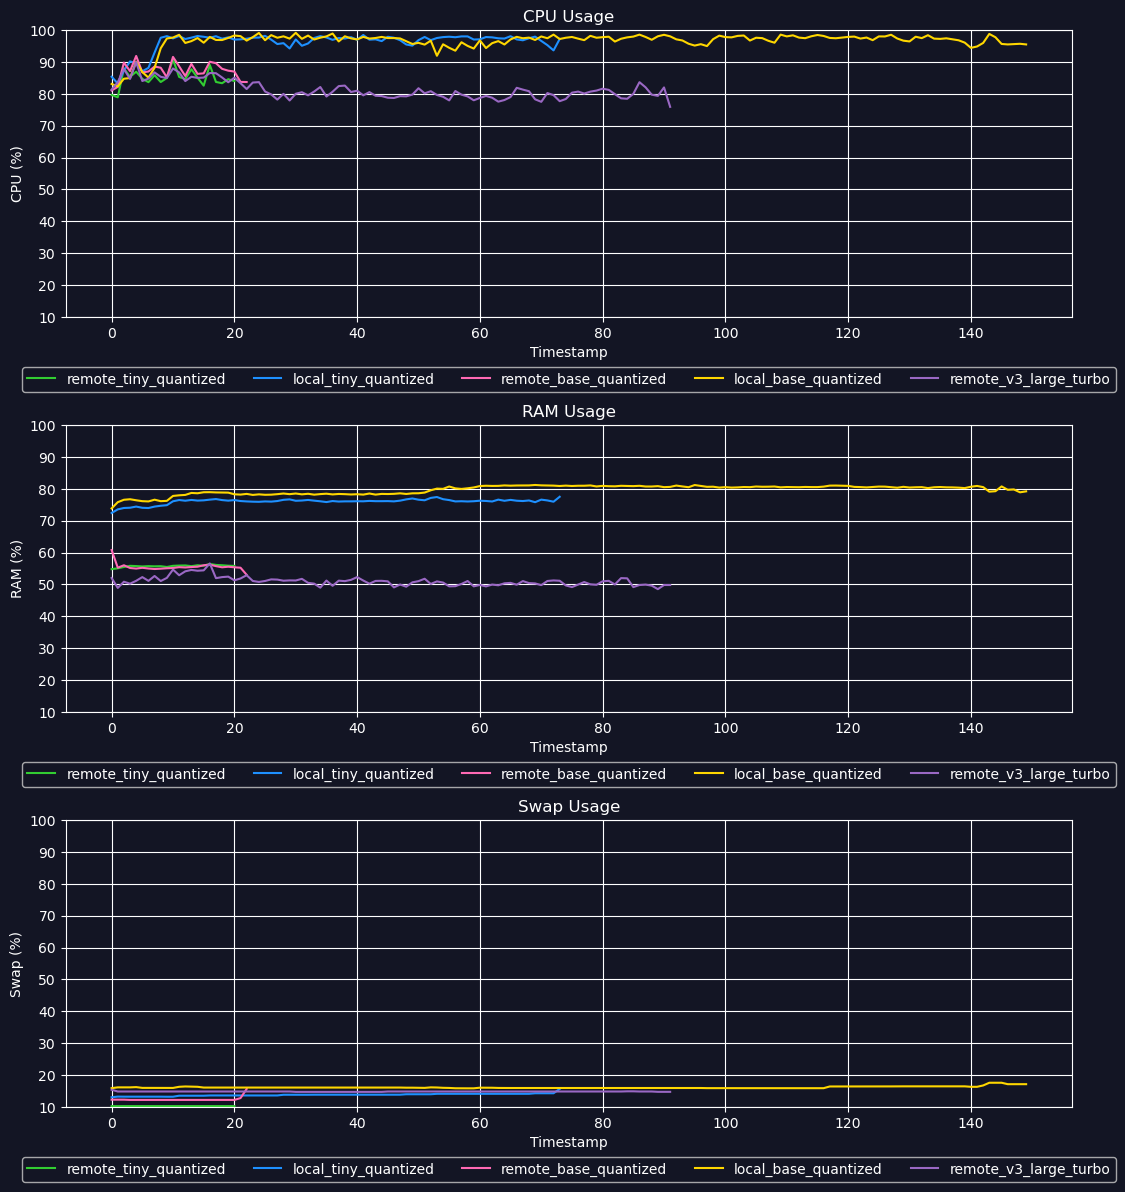

In [7]:
ExManager.plot_cpu_ram_swap(plotci=False)

[INFO] Mean FPS for remote_tiny_quantized: 2.1635406771578443
[INFO] Mean FPS for local_tiny_quantized: 1.4727291246110739
[INFO] Mean FPS for remote_base_quantized: 2.0577680301998793
[INFO] Mean FPS for local_base_quantized: 1.4904374249516896
[INFO] Mean FPS for remote_v3_large_turbo: 2.0256392639501897


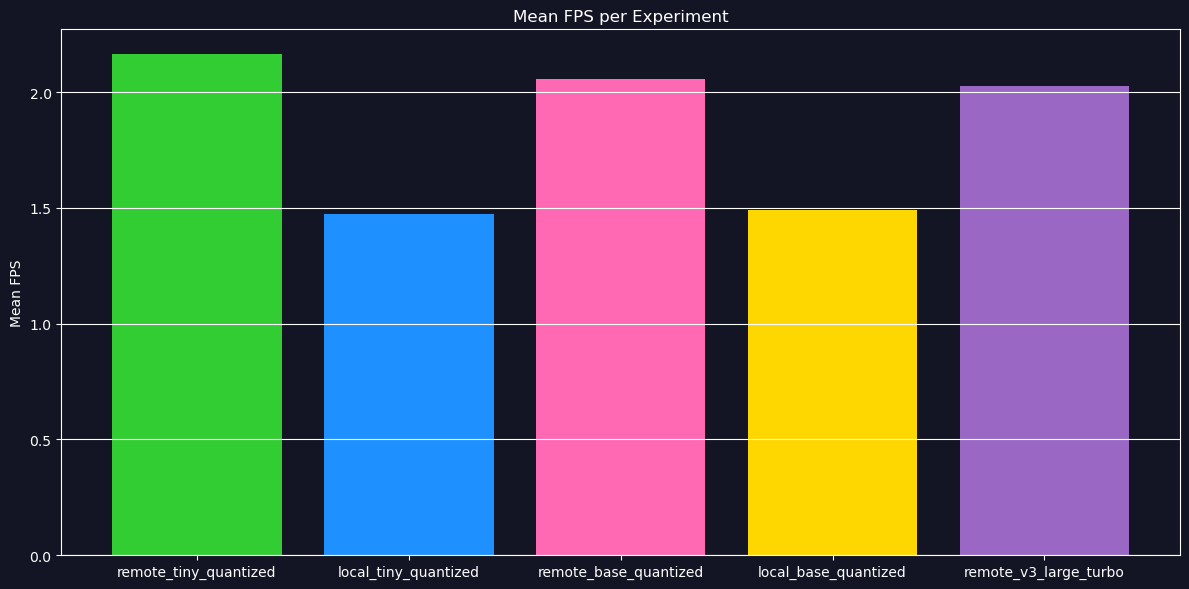

In [8]:
ExManager.plot_fps(plotci=False)

C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:310: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(names, rotation=0)
C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:323: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(names, rotation=0)


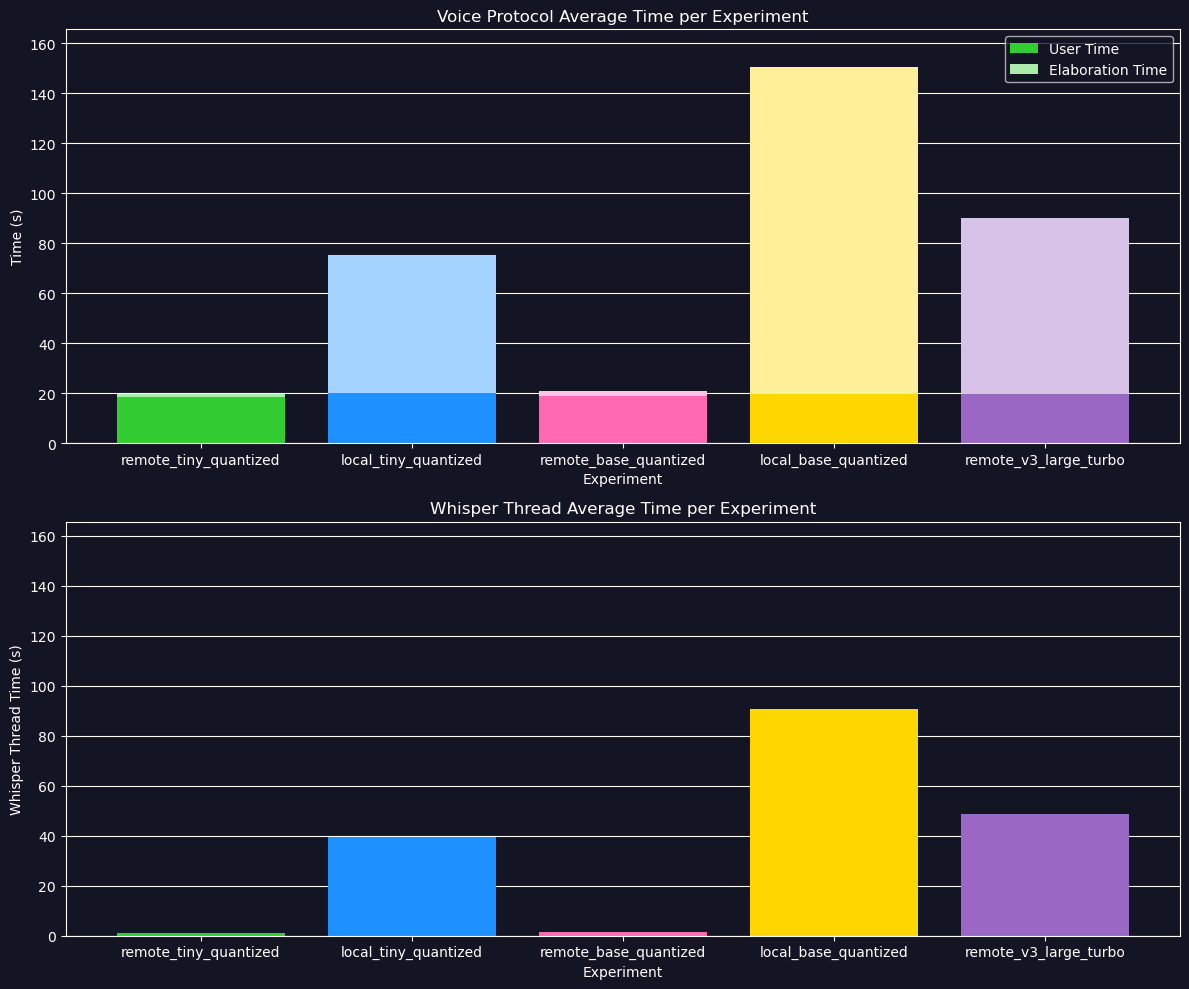

In [9]:
ExManager.plot_inference_time()

[INFO] Plot saved to img/cpu_ram_swap_plot.png
[INFO] Mean FPS for remote_tiny_quantized: 2.1635406771578443
[INFO] Mean FPS for local_tiny_quantized: 1.4727291246110739
[INFO] Mean FPS for remote_base_quantized: 2.0577680301998793
[INFO] Mean FPS for local_base_quantized: 1.4904374249516896
[INFO] Mean FPS for remote_v3_large_turbo: 2.0256392639501897
[INFO] Plot saved to img/fps_plot.png


C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:310: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(names, rotation=0)
C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:323: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(names, rotation=0)


[INFO] Plot saved to img/inference_plot.png
[INFO] All figures saved successfully.


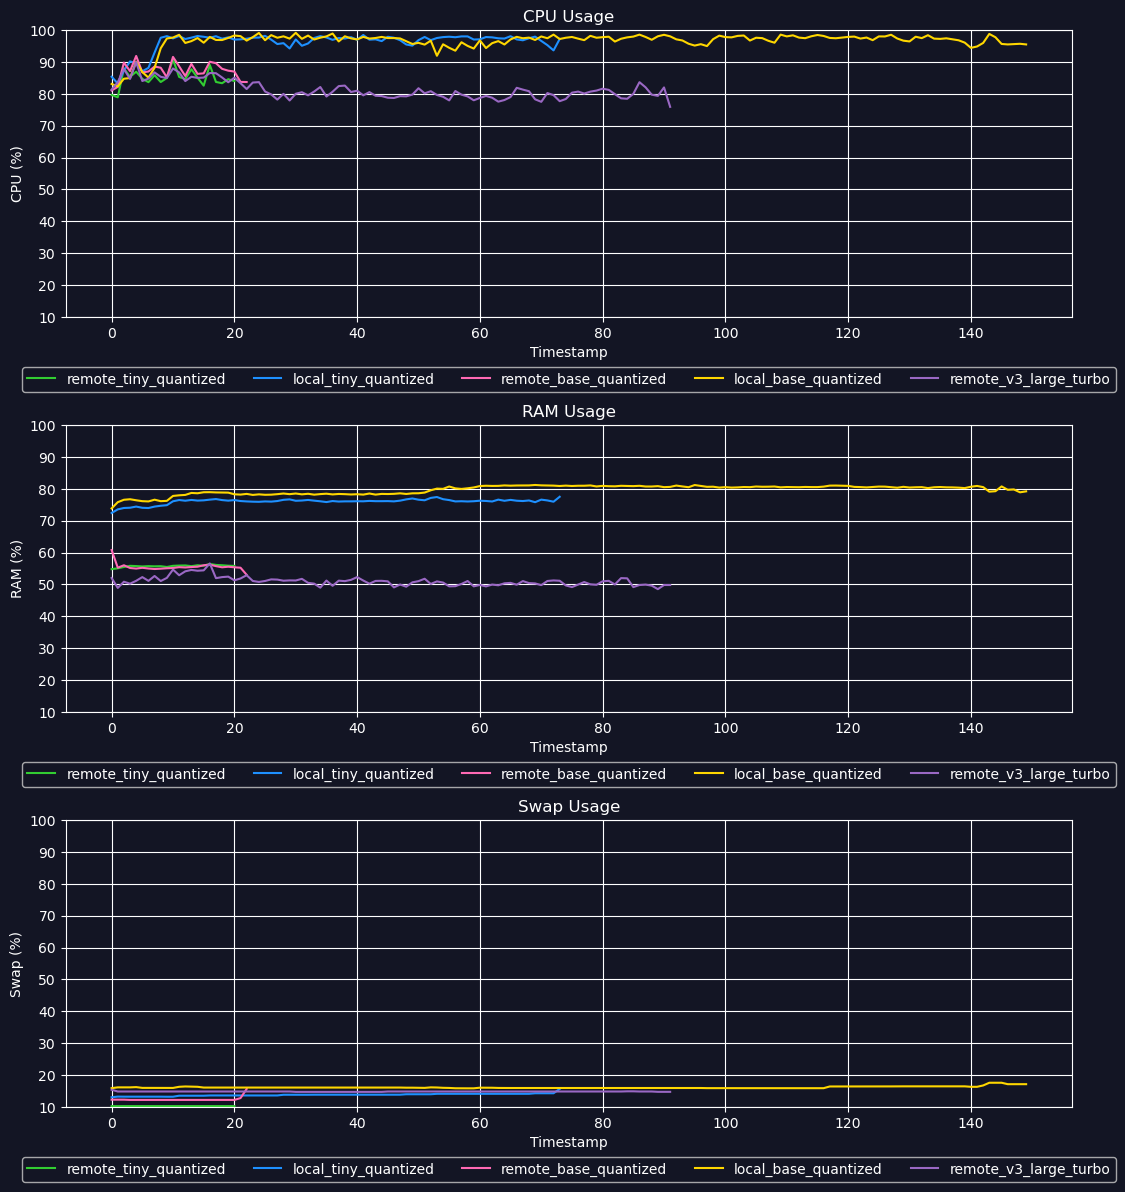

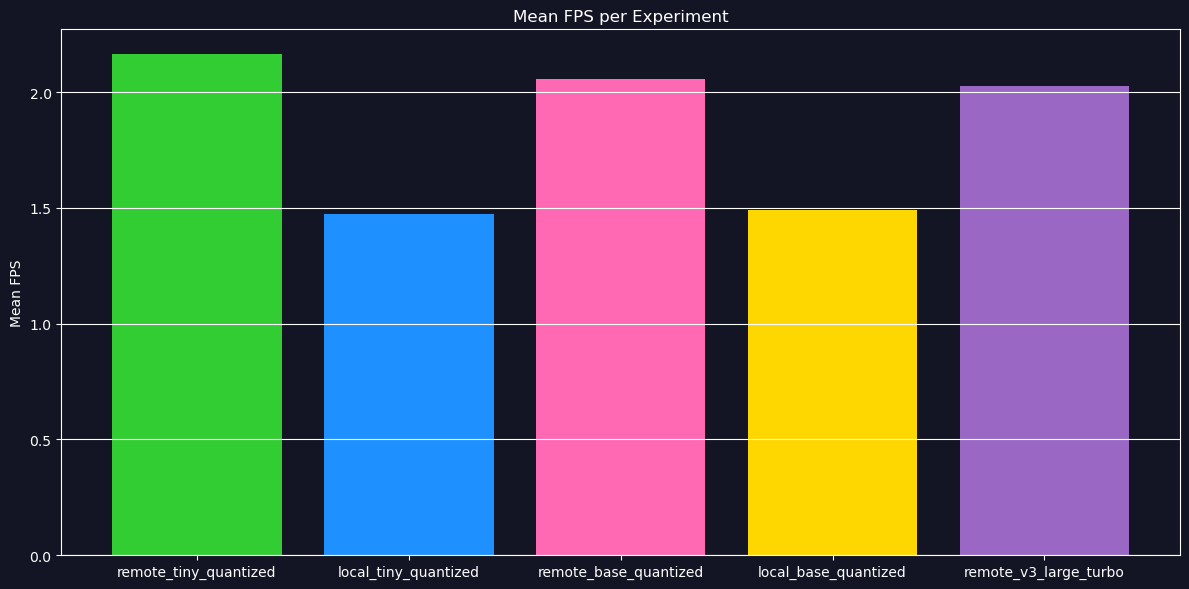

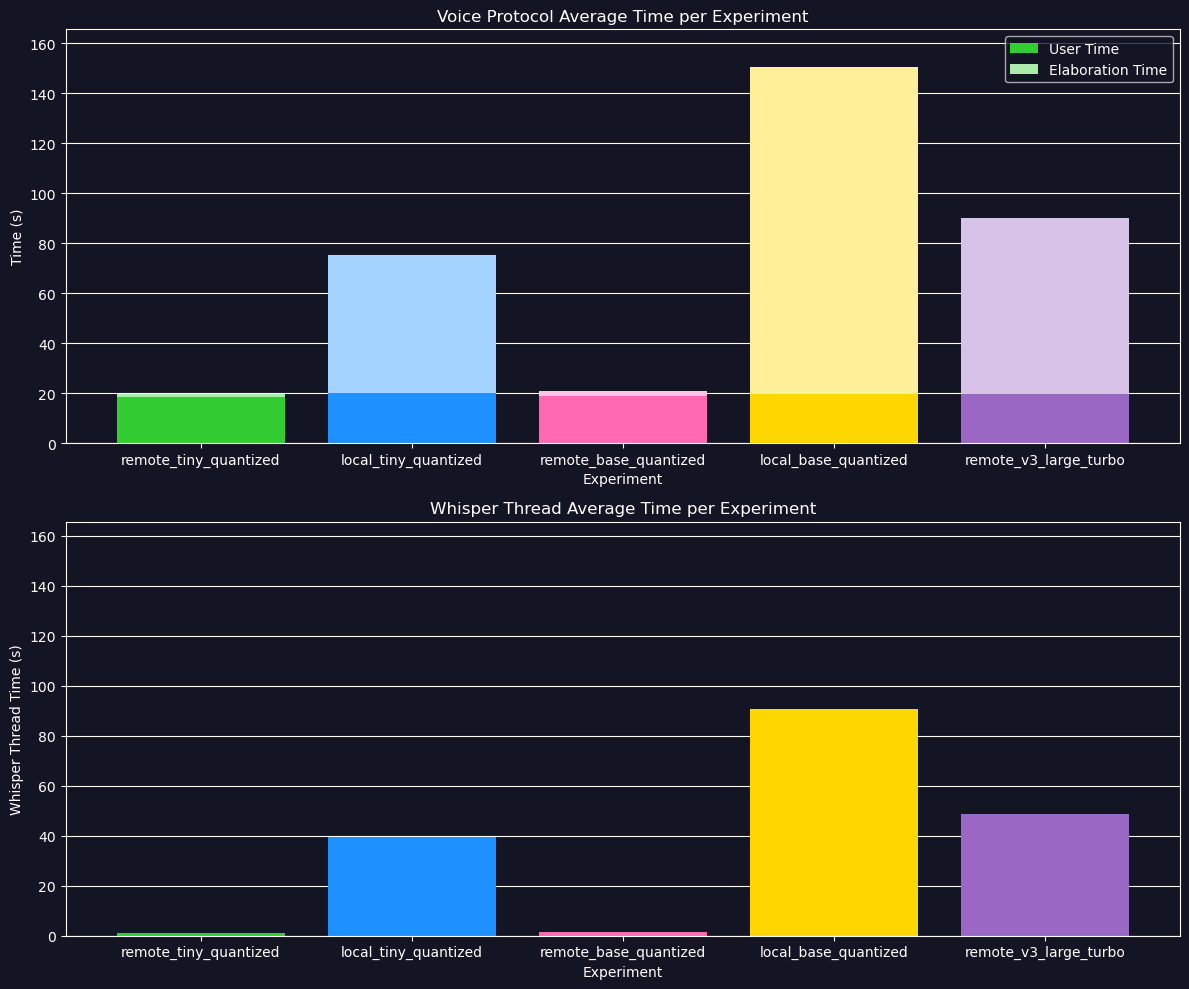

In [11]:
ExManager.save_all_figures()

In [12]:
CPUUsageManager = ExperimentManager(data_path=CPU_DATA_PATH)
CPUUsageManager.set_dark_mode(True)
CPUUsageManager.init_all()

[INFO] Experiment local_tiny_quantized_per_proc_cpu_usage loaded with 5 repetitions.
[INFO] Experiment local_tiny_quantized_no_graphicap_interface_shown loaded with 8 repetitions.


C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:51: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  sem_df = pd.DataFrame(stats.sem([df.values for df in pad_df], axis=0, nan_policy='omit'), columns=pad_df[0].columns)
C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:51: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  sem_df = pd.DataFrame(stats.sem([df.values for df in pad_df], axis=0, nan_policy='omit'), columns=pad_df[0].columns)
C:\Users\User\AppData\Local\Temp\ipykernel_11856\3288711065.py:51: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements

[INFO] Mean FPS for local_tiny_quantized_per_proc_cpu_usage: 0.8421658965037268
[INFO] Mean FPS for local_tiny_quantized_no_graphicap_interface_shown: 1.192456837642644


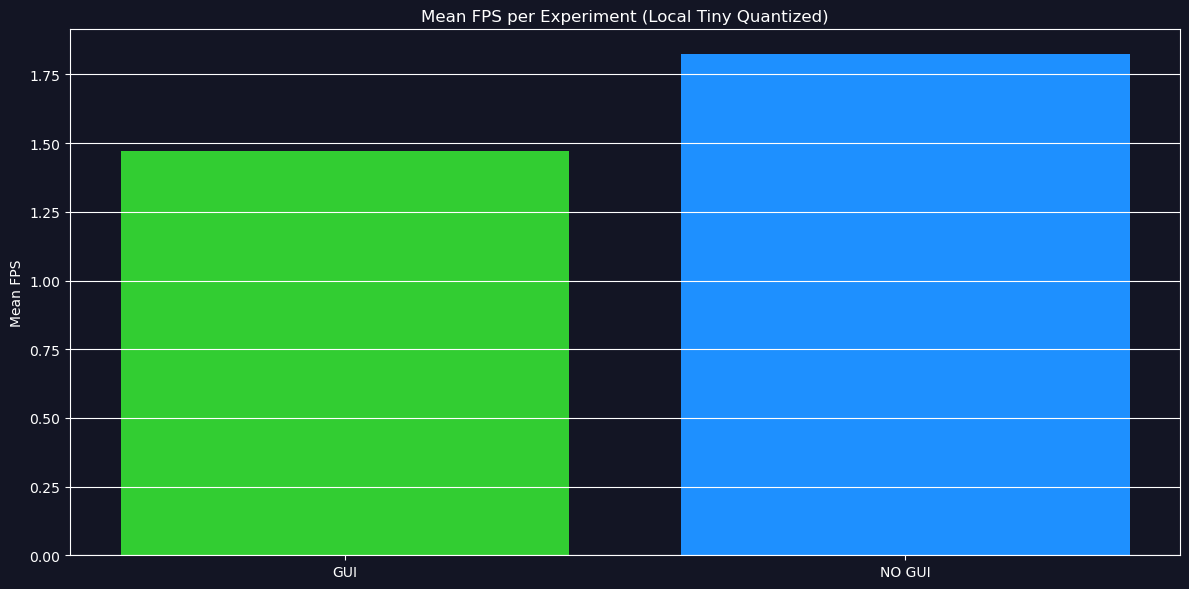

In [ ]:
new_names = [
    'GUI',
    'NO GUI'
]

CPUUsageManager.plot_fps(plotci=False, new_names=new_names, title ="Mean FPS per Experiment (Local Tiny Quantized)")

In [14]:
CPUUsageManager.experiments["local_tiny_quantized_per_proc_cpu_usage"].cpu_usage.head()

,ID,CPU_self,CPU_whisper,CPU_labwc,CPU_self_ci_lower,CPU_self_ci_upper,CPU_whisper_ci_lower,CPU_whisper_ci_upper,CPU_labwc_ci_lower,CPU_labwc_ci_upper
0,0.0,187.82,30.24,54.68,144.373863,231.266137,3.141578,57.338422,31.715129,77.644871
1,1.0,257.84,0.00,72.58,179.376372,336.303628,0.000000,0.000000,41.741683,103.418317
2,2.0,180.96,0.00,67.20,174.792660,187.127340,0.000000,0.000000,63.242961,71.157039
3,3.0,165.96,0.00,67.80,164.167656,167.752344,0.000000,0.000000,53.791578,81.808422
4,4.0,142.66,0.00,53.00,135.677495,149.642505,0.000000,0.000000,47.612792,58.387208


[INFO] Plot saved to img/cpu_usage_plot.png


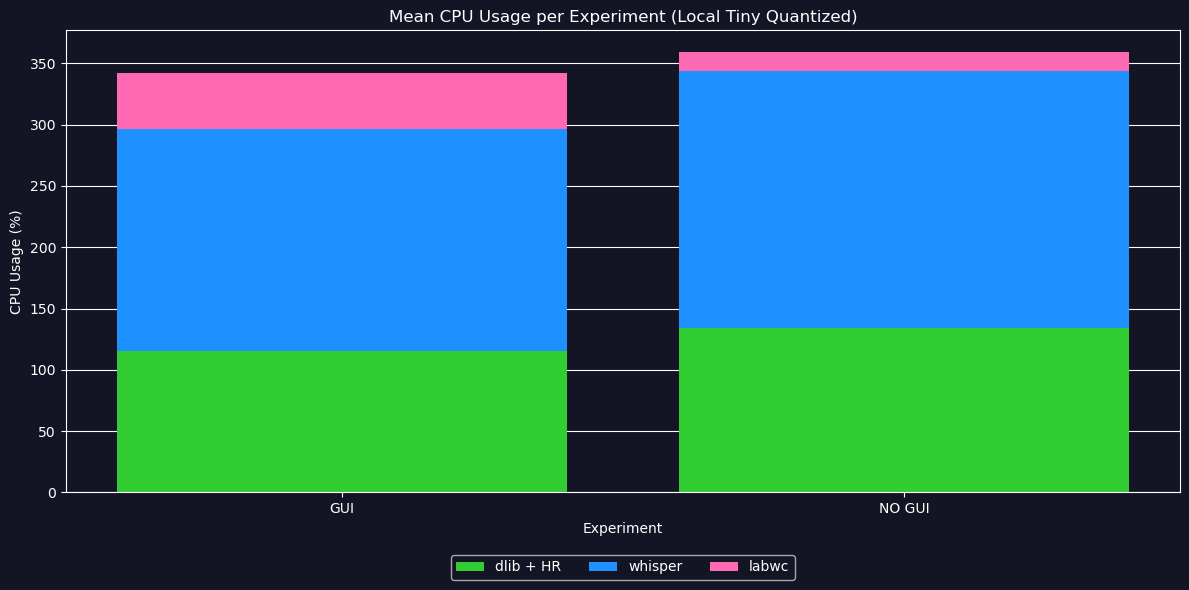

In [15]:
new_names = [
    'GUI',
    'NO GUI'
]
CPUUsageManager.plot_cpu_usage(new_names=new_names, save=True)

[INFO] Plot saved to img/cpu_usage_cake_plot.png


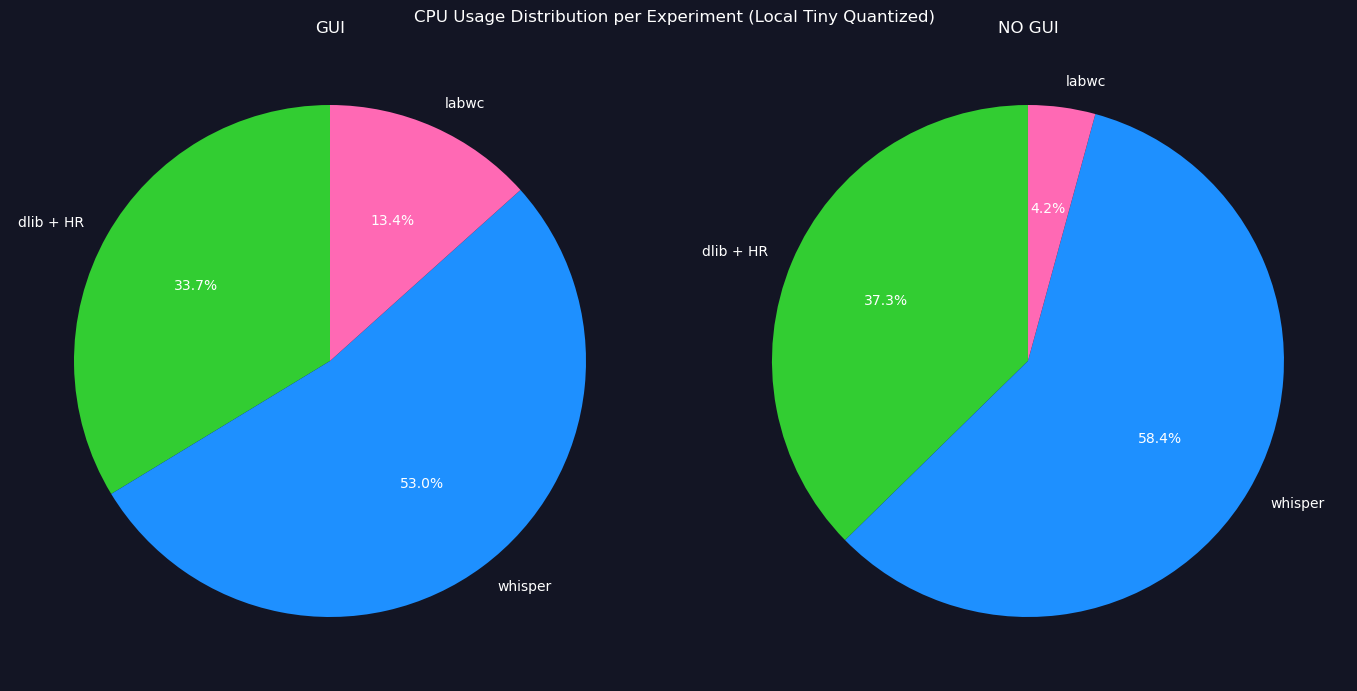

In [16]:
CPUUsageManager.plot_cpu_usage_cake(new_names=new_names, save=True)